In [5]:
import pandas as pd
pd.set_option('max_colwidth', 1000)
import numpy as np
import os
import csv
import multiprocessing as mp
import re
from datetime import datetime

from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import matplotlib

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pickle
from shapely.geometry import Polygon, mapping



import warnings
warnings.filterwarnings("ignore")

fire_dataset = "firedata/"

### Downloaded data from NASA FIRM, MODIS instrument data for India from 2010 to 2020.


In [6]:
def check_point(point,polygons):
    for polygon in polygons:
        if polygon.contains(point):
            return True
    return False

def get_fire_df_filter_states(df_stubble,states=["Punjab","Haryana"],
                              shp_file="choropleth_plot/india/kaggle/output.shp",state_col="statename"):
    gdf = gpd.read_file(shp_file)
    gdf_states = gdf[gdf[state_col].isin(states)]
    polygons = gdf_states["geometry"]
    df_fire_states = df_stubble[df_stubble["Point"].apply(check_point,polygons=polygons)]
    return df_fire_states

In [7]:
#df_fire_states = get_fire_df_filter_states(df_stubble)
#df_fire_states.to_csv("files/firecount_dataset_punjab_haryana_modis.csv.dz",compression="gzip")
instrument = "VIIRS"
#instrument = "MODIS"
states = ["Haryana","Punjab"]
dfs = []
for state in states:
    fname = f"{state}_2012_20_{instrument}"
    df_fire_states = pd.read_csv(os.path.join(fire_dataset,fname,"fire_archive.csv"))
    df_fire_states["acq_date"] = pd.to_datetime(df_fire_states["acq_date"])
    #df_fire_states = df_fire_states[df_fire_states["type"] == 0]
    before = len(df_fire_states)
    df_fire_states = df_fire_states[df_fire_states["confidence"].isin(["n","h"])]
    after = len(df_fire_states)
    dfs.append(df_fire_states)
df_fire_states = pd.concat(dfs)
df_fire_states

,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,daynight,type
0,30.150801,76.900604,335.06,0.44,0.46,2012-01-20,730,N,VIIRS,n,1,288.54,2.53,D,0
1,30.435675,77.133965,328.66,0.42,0.45,2012-01-20,730,N,VIIRS,n,1,287.80,3.14,D,0
2,29.459030,76.864166,309.48,0.38,0.59,2012-01-20,1954,N,VIIRS,n,1,279.06,1.81,N,2
3,29.458715,76.868240,303.02,0.38,0.59,2012-01-20,1954,N,VIIRS,n,1,278.59,1.16,N,2
4,29.455458,76.875244,298.40,0.63,0.72,2012-01-20,2134,N,VIIRS,n,1,277.83,1.47,N,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735619,30.680571,76.756721,300.68,0.40,0.37,2021-03-31,2030,N,VIIRS,n,1,289.04,0.52,0,0
735620,31.212080,76.226295,311.27,0.41,0.37,2021-03-31,2030,N,VIIRS,n,1,284.06,1.37,0,0
735621,30.937761,76.741707,301.22,0.40,0.37,2021-03-31,2030,N,VIIRS,n,1,289.60,0.84,0,0
735622,30.856295,75.929977,298.40,0.42,0.38,2021-03-31,2030,N,VIIRS,n,1,287.59,0.40,0,0


In [8]:
#group by date
which_fire_df = df_fire_states

stubble_daily = which_fire_df.groupby("acq_date").count().reset_index()

In [9]:
def get_regex_string_from_single_word(keyword,space=False,dostrip=True):
    
    #to check empty string before the keyword
    re_str = ""
    space = ""
    if space:
        space = "\\b"
        re_str+=space
    keyword = keyword.lower()
    if dostrip:
        keyword = keyword.strip()
    words = keyword.split(" ")
    n = len(words)
    for ind,word in enumerate(words):
        re_str+=word
        if ind+1 < n:
            #to accept white space between two word
            re_str+="\\s"
    
    #to check empty string after the keyword
    re_str+= space
    return re_str

def get_matches(text,queries,print_re=False,print_matches=False,dostrip=True):
    '''
    regex serach from text using queris
    returns list of keyword matches
    '''
    re_str = ""
    for each in queries:
        re_str = re_str + get_regex_string_from_single_word(each,dostrip) + "|"
    re_str = re_str[:-1]
    if print_re:
        print(re_str)
    if print_matches:
        print(re.findall(re_str,text,flags=re.I))
    return re.findall(re_str,text,flags=re.I)


def get_dailybasis_articledf_queries(df,queries,key,start_date = datetime(2010,1,1).date(),end_date = datetime(2021,5,30).date()):
    '''
    returns df with each dates included between given range & 
    gives count of articles matching qith query
    '''
    column="heading_and_content"
    
    #combine heading & content
    df[column] = df.apply(lambda x:x["heading"] + " " + x["content"],axis=1)
    
    #get matches of queries
    df[key] = df[column].apply(get_matches,queries=queries,print_matches=False)
    
    #put 1 if query present otherwise 0
    df[key] = df[key].apply(lambda x:int(len(x)>0))

    #group by date for daily basis
    final_df =  pd.concat([df.groupby("date").count()["url"],df.groupby("date").sum()[key]],axis=1)
    
    #range of all date
    date_idx = pd.date_range(start_date, end_date)
    
    #fill missing dates
    final_df = final_df.reindex(date_idx,fill_value=0)
    
    return final_df

In [10]:
def latexify(fig_width=None, fig_height=None, columns=2):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.32 if columns==1 else 6.75 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': [r'\usepackage{gensymb}'],
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
              'font.size': 8, # was 10
              'legend.fontsize': 8, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)


def format_axes(ax,twinx=False,SPINE_COLOR="gray"):
    
    if twinx:
        for spine in ['top']:
            ax.spines[spine].set_visible(False)

        for spine in ['left', 'bottom', 'right']:
            ax.spines[spine].set_color(SPINE_COLOR)
            ax.spines[spine].set_linewidth(0.5)
        
    else:
        for spine in ['top', 'right']:
            ax.spines[spine].set_visible(False)

        for spine in ['left', 'bottom']:
            ax.spines[spine].set_color(SPINE_COLOR)
            ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

In [11]:
df = pd.read_csv("../dataset/News_articles_dataset/News_articles_dataset.csv.gz")
df["date"] = pd.to_datetime(df["date"])

df_filter = df[df["state"].isin(["punjab","haryana","delhi"])]
print(len(df_filter))

stubble_burning = {
    "stubble burning":["crop burning","stubble","burning crops?",
                       "burning paddy","paddy burning","crop residue"]
}
col = "stubble burning"
stubble_art_df = get_dailybasis_articledf_queries(df_filter,stubble_burning["stubble burning"],col)
query_articles = stubble_art_df[col].sum()
print(f"{col} = {query_articles} articles")
stubble_art_df

6410
stubble burning = 1280 articles


,url,stubble burning
2010-01-01,0,0
2010-01-02,0,0
2010-01-03,0,0
2010-01-04,0,0
2010-01-05,0,0
...,...,...
2021-05-26,0,0
2021-05-27,0,0
2021-05-28,0,0
2021-05-29,0,0


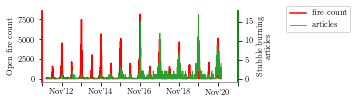

In [22]:
latexify(fig_height=1.3,fig_width=3.5)
#karmify()

fig,ax = plt.subplots()
which_art_df = stubble_art_df
which_fire_df = df_fire_states

#start_date, end_date = which_fire_df["acq_date"].min(), which_fire_df["acq_date"].max()
start_date = datetime(2012,1,1)
end_date = datetime(2020,12,31)

which_art_df = which_art_df[start_date:end_date]

stubble_daily = which_fire_df[which_fire_df.type == 0].groupby("acq_date").count().reset_index()
stubble_daily = stubble_daily[stubble_daily["acq_date"].isin(pd.date_range(start_date,end_date))]

ax2 = ax.twinx()
plt1 = ax.plot(stubble_daily["acq_date"],stubble_daily["type"],label="fire count",color="red")
plt2 = ax2.plot(which_art_df.index,which_art_df["stubble burning"],label="articles",linewidth=0.8,color="tab:green")



#set which month to show
ax.set_xlim(datetime(2011,11,1), datetime(2021,11,1))

#set format of date
date_form = DateFormatter("%b'%y")
#ax = fig.axes[0]
ax.xaxis.set_major_formatter(date_form)

#make interval of n months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.tick_params(axis="x",rotation=0)
ticks = ax.get_xticklabels()



#
ax.set_ylabel("Open fire count")
#ax.set_xlabel("Day")
ax2.set_ylabel("Stubble burning\narticles")

#set legend
plts = plt1+plt2
labs = [l.get_label() for l in plts]
ax.legend(plts,labs,loc=(1.25,0.7));

for spine in ['top']:
    ax.spines[spine].set_visible(False)
    ax2.spines[spine].set_visible(False)

for spine in ['bottom']:
    ax.spines[spine].set_color("gray")
    ax2.spines[spine].set_color("gray")
    ax.spines[spine].set_linewidth(0.5)
    ax2.spines[spine].set_linewidth(0.5)

plt.draw()

for idx,tick in enumerate(ticks):
    if idx%2 == 0:
        tick.set_text("")
#print(ticks)
ax.set_xticklabels(ticks);

yticks = ax.get_yticklabels()
for tick in yticks:
    val = tick.get_text()
    try:
        val = int(val.split("{")[1][:-2])
        val = val//1000
        tick.set_text(str(val)+"K")
        #print(tick.get_text())
    except:
        pass
    
ax.set_yticklabels(yticks);
ax.spines["left"].set_color("red")
ax.spines["right"].set_color("green")
ax.spines["left"].set_linewidth(1.5)
ax.spines["right"].set_linewidth(1.5)

ax2.spines["left"].set_color("red")
ax2.spines["right"].set_color("green")
ax2.spines["left"].set_linewidth(1.5)
ax2.spines["right"].set_linewidth(1.5)

#ax.grid()
#

In [23]:
fig.savefig("../figures/fig8_timeseries_stubble_burning.pdf",bbox_inches="tight")